<a href="https://colab.research.google.com/github/qingemeng/cs598dlh-final/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import random as python_random
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix


# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)
RANDOM_STATE = 42

In [3]:

import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/DLH deep learning in healthcare/dlh-data.csv')

In [4]:
df

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,agecode
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,N,P,P,P,N,1
1,F,30,Yes,M,ARTISAN,Yes,S,Yes,No,Yes,Yes,P,P,P,N,N,1
2,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,P,P,P,N,P,1
3,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,P,P,N,N,P,2
4,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,P,P,P,P,P,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes,P,N,P,N,P,3
496,F,50,No,M,ARTISAN,No,M,Yes,No,No,No,P,P,N,P,P,2
497,F,32,No,C,FORCE,No,M,No,No,No,Yes,N,P,P,P,N,2
498,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No,N,P,N,N,N,1


## Data preprocessing
1. one-hot encoded input features and targets
2. Convert two-class feature to binary data

In [5]:
def one_hot_encode(data):
  # binary encode
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = data.reshape(len(data), 1)
  return onehot_encoder.fit_transform(integer_encoded)

In [6]:
df['age'] = df['agecode']
data = np.array(df)

X = data[:, 0:11]
X[X=='Yes'] = 1
X[X=='No'] = 0

ages = X[:, 1]
religions = X[:, 3]
occupations = X[:, 4]
X = np.delete(X, (1, 3, 4), axis = 1)

# one-hot encode age
onehot_encoded_ages = one_hot_encode(ages)
X = np.append(X, onehot_encoded_ages, axis = 1)
# print(X[:10])

# one-hot encode religion

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(religions)
onehot_encoded_religions = one_hot_encode(integer_encoded)
X = np.append(X, onehot_encoded_religions, axis = 1)
# print(X[:10])

# one-hot encode occupation
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(occupations)
onehot_encoded_occupations = one_hot_encode(integer_encoded)
X = np.append(X, onehot_encoded_occupations, axis = 1)
assert X.shape == (500, 20)

X[X=='S'] = 0
X[X=='M'] = 1

X[X=='F'] = 0
X[X=='M'] = 1
X = X.astype('int32')

Y = data[:, 11:-1] 
Y[Y=='P'] = 1
Y[Y=='P       \x1c'] = 1
Y[Y=='N'] = 0
Y[Y=='N       \x1a'] = 0

Y = Y.astype('int32')

In [7]:
X

array([[1, 1, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0]], dtype=int32)

In [8]:
Y

array([[0, 1, 1, 1, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1],
       ...,
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0]], dtype=int32)

## Define the mlp model

In [29]:
def build_mlp_model(out_put_size, dropout_rate = 0.1, single_layer = False):
  model = Sequential()
  model.add(Dense(15, input_dim=20, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(20, activation='relu'))
  if(not single_layer):
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(40, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(out_put_size, activation='sigmoid'))
  opt = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
  return model


### Multi-label DL-MLP with class imbalance



Fit the model

In [32]:
dnn_mlp = build_mlp_model(5)
dnn_mlp.count_params()

2100

Epoch 1/40
11/11 [==============================] - 1s 20ms/step - loss: 0.6628 - accuracy: 0.1229 - val_loss: 0.5982 - val_accuracy: 0.2333
Epoch 2/40
11/11 [==============================] - 0s 5ms/step - loss: 0.6151 - accuracy: 0.4000 - val_loss: 0.5874 - val_accuracy: 0.7400
Epoch 3/40
11/11 [==============================] - 0s 6ms/step - loss: 0.5992 - accuracy: 0.4371 - val_loss: 0.5811 - val_accuracy: 0.5933
Epoch 4/40
11/11 [==============================] - 0s 6ms/step - loss: 0.5873 - accuracy: 0.3857 - val_loss: 0.5192 - val_accuracy: 0.6933
Epoch 5/40
11/11 [==============================] - 0s 5ms/step - loss: 0.5855 - accuracy: 0.3971 - val_loss: 0.5422 - val_accuracy: 0.6667
Epoch 6/40
11/11 [==============================] - 0s 5ms/step - loss: 0.5709 - accuracy: 0.4600 - val_loss: 0.5238 - val_accuracy: 0.7267
Epoch 7/40
11/11 [==============================] - 0s 6ms/step - loss: 0.5788 - accuracy: 0.4200 - val_loss: 0.5129 - val_accuracy: 0.7333
Epoch 8/40
11/11 [=

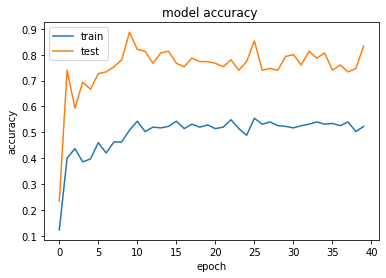

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss')
history = dnn_mlp.fit(X, Y, epochs=40, validation_split=0.3)

print(history.history['accuracy'])
print(history.history['val_accuracy'])


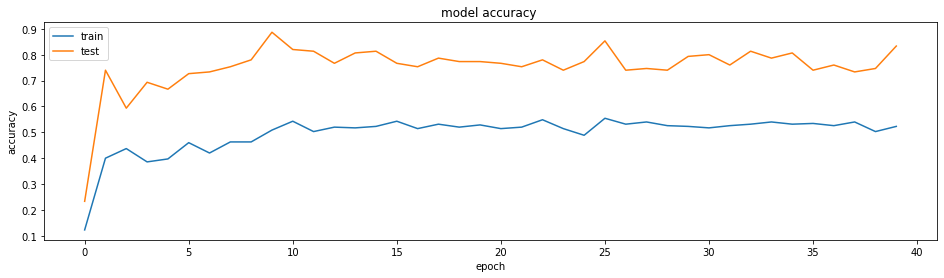

In [ ]:
plt.figure(figsize=(16,4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

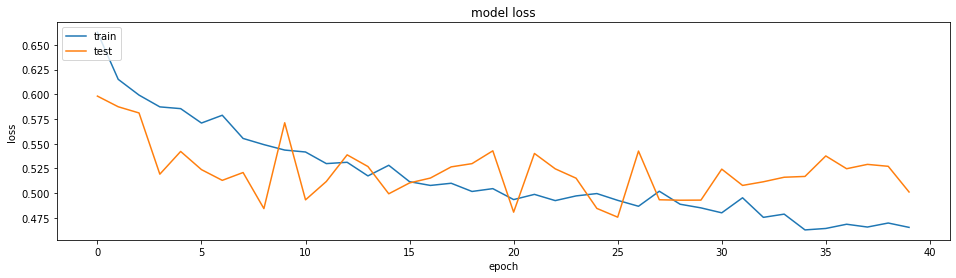

In [ ]:
plt.figure(figsize=(16,4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Single-label DL-MLP with class imbalance


In [36]:
dnn_mlp_single = build_mlp_model(1)
dnn_mlp_single.count_params()

1936

[0.48571428656578064, 0.5314285755157471, 0.522857129573822, 0.5400000214576721, 0.5657142996788025, 0.5628571510314941, 0.6399999856948853, 0.631428599357605, 0.6428571343421936, 0.645714282989502, 0.631428599357605, 0.6514285802841187, 0.6114285588264465, 0.631428599357605, 0.5971428751945496, 0.6885714530944824, 0.6571428775787354, 0.6742857098579407, 0.6742857098579407, 0.6657142639160156, 0.6714285612106323, 0.7028571367263794, 0.6971428394317627, 0.6857143044471741, 0.6714285612106323, 0.7057142853736877, 0.691428542137146, 0.7057142853736877, 0.6657142639160156, 0.6600000262260437, 0.7085714340209961, 0.6857143044471741, 0.6742857098579407, 0.6885714530944824, 0.7085714340209961, 0.6971428394317627, 0.6942856907844543, 0.7057142853736877, 0.7142857313156128, 0.7142857313156128]
[0.7866666913032532, 0.753333330154419, 0.746666669845581, 0.7866666913032532, 0.8333333134651184, 0.846666693687439, 0.699999988079071, 0.7933333516120911, 0.7133333086967468, 0.7799999713897705, 0.63999

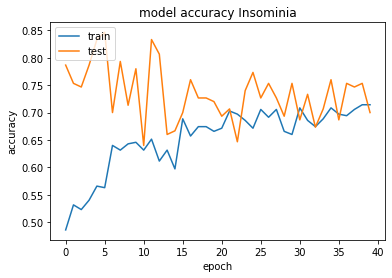

[0.7400000095367432, 0.8028571605682373, 0.8028571605682373, 0.831428587436676, 0.8771428465843201, 0.8828571438789368, 0.8942857384681702, 0.8942857384681702, 0.8999999761581421, 0.9028571248054504, 0.9057142734527588, 0.8971428275108337, 0.9085714221000671, 0.9057142734527588, 0.9085714221000671, 0.8999999761581421, 0.9171428680419922, 0.8885714411735535, 0.8999999761581421, 0.9114285707473755, 0.9114285707473755, 0.9171428680419922, 0.9057142734527588, 0.9114285707473755, 0.9114285707473755, 0.9114285707473755, 0.9257143139839172, 0.9085714221000671, 0.9142857193946838, 0.9085714221000671, 0.9057142734527588, 0.9200000166893005, 0.9142857193946838, 0.9142857193946838, 0.9200000166893005, 0.9228571653366089, 0.9171428680419922, 0.9028571248054504, 0.9314285516738892, 0.9142857193946838]
[0.9599999785423279, 0.9599999785423279, 0.9599999785423279, 0.9200000166893005, 0.8733333349227905, 0.9333333373069763, 0.9333333373069763, 0.9066666960716248, 0.8999999761581421, 0.8933333158493042,

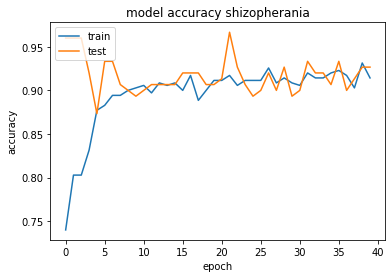

[0.7257142663002014, 0.7485714554786682, 0.7485714554786682, 0.7485714554786682, 0.7485714554786682, 0.7657142877578735, 0.7571428418159485, 0.800000011920929, 0.7857142686843872, 0.7971428632736206, 0.808571457862854, 0.800000011920929, 0.7857142686843872, 0.8142856955528259, 0.808571457862854, 0.8199999928474426, 0.8342857360839844, 0.8199999928474426, 0.8028571605682373, 0.822857141494751, 0.8285714387893677, 0.8485714197158813, 0.8342857360839844, 0.8342857360839844, 0.8628571629524231, 0.8485714197158813, 0.822857141494751, 0.8371428847312927, 0.8428571224212646, 0.845714271068573, 0.8771428465843201, 0.831428587436676, 0.868571400642395, 0.8514285683631897, 0.8371428847312927, 0.8199999928474426, 0.8199999928474426, 0.8485714197158813, 0.868571400642395, 0.8714285492897034]
[0.5600000023841858, 0.5600000023841858, 0.5600000023841858, 0.5600000023841858, 0.5600000023841858, 0.5400000214576721, 0.5733333230018616, 0.5799999833106995, 0.5933333039283752, 0.6600000262260437, 0.646666

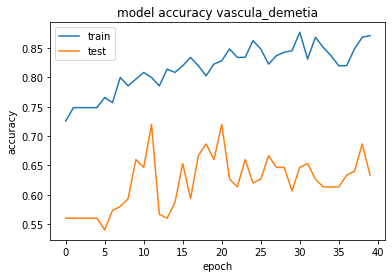

[0.5685714483261108, 0.5914285778999329, 0.5857142806053162, 0.5914285778999329, 0.5971428751945496, 0.5942857265472412, 0.6114285588264465, 0.6057142615318298, 0.6228571534156799, 0.6085714101791382, 0.6028571724891663, 0.6200000047683716, 0.6885714530944824, 0.6114285588264465, 0.6800000071525574, 0.6342856884002686, 0.6628571152687073, 0.6571428775787354, 0.668571412563324, 0.7142857313156128, 0.6942856907844543, 0.6800000071525574, 0.7285714149475098, 0.7028571367263794, 0.7371428608894348, 0.7114285826683044, 0.6800000071525574, 0.7314285635948181, 0.7142857313156128, 0.7571428418159485, 0.7371428608894348, 0.7542856931686401, 0.699999988079071, 0.7428571581840515, 0.7228571176528931, 0.7171428799629211, 0.7257142663002014, 0.7314285635948181, 0.7257142663002014, 0.7114285826683044]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6200000047683716, 0.5799999833106995, 0.6200000047683716, 0.6733333468437195, 0.6666666865348816, 0.6399999856948853, 0.6733333468437195, 0.653333306312561, 0

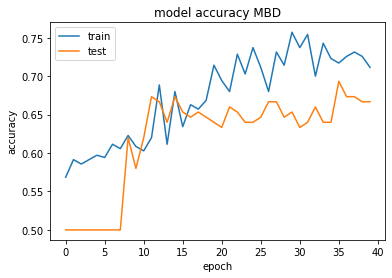

[0.5314285755157471, 0.5600000023841858, 0.5314285755157471, 0.5942857265472412, 0.6228571534156799, 0.5942857265472412, 0.654285728931427, 0.6514285802841187, 0.6571428775787354, 0.6657142639160156, 0.6885714530944824, 0.654285728931427, 0.6657142639160156, 0.6714285612106323, 0.7114285826683044, 0.6885714530944824, 0.7171428799629211, 0.7171428799629211, 0.6742857098579407, 0.7171428799629211, 0.7171428799629211, 0.7200000286102295, 0.7028571367263794, 0.699999988079071, 0.7200000286102295, 0.7371428608894348, 0.7342857122421265, 0.7228571176528931, 0.7142857313156128, 0.7514285445213318, 0.7428571581840515, 0.7057142853736877, 0.7428571581840515, 0.7400000095367432, 0.7085714340209961, 0.7228571176528931, 0.7057142853736877, 0.7314285635948181, 0.7599999904632568, 0.7485714554786682]
[0.7400000095367432, 0.7599999904632568, 0.6266666650772095, 0.746666669845581, 0.746666669845581, 0.8199999928474426, 0.7200000286102295, 0.7933333516120911, 0.7733333110809326, 0.7133333086967468, 0.6

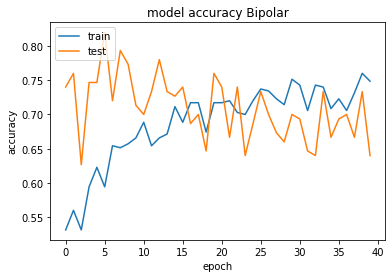

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss')
deseases = ['Insominia',	'shizopherania',	'vascula_demetia',	'MBD',	'Bipolar']
drop_out_rates = [0.4, 0.2, 0.1, 0.4, 0.3]
for i, desease in enumerate(deseases):
  dnn_mlp_single = build_mlp_model(1, dropout_rate=drop_out_rates[i])
  history = dnn_mlp_single.fit(X, Y[:, i], epochs=40, validation_split=0.3, verbose = 0)
  print(history.history['accuracy'])
  print(history.history['val_accuracy'])
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy ' + desease)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


## Class balance and over-sample using SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
multi_hot_Y = []
for row in Y:
  target = ""
  for col in row:
    target = target + (str(col))
  multi_hot_Y.append(target)
print(multi_hot_Y)

['01110', '11100', '11101', '11001', '11111', '01100', '11111', '11101', '11111', '01100', '11111', '11111', '01000', '01111', '01110', '01110', '11111', '11100', '11111', '01110', '11111', '10001', '10001', '11111', '11001', '11101', '10011', '00000', '01110', '11111', '00000', '10011', '10111', '11001', '11011', '00100', '00110', '01000', '00000', '01110', '01010', '11101', '10011', '11101', '01100', '01010', '11001', '00100', '00000', '10111', '01000', '11101', '00110', '10101', '01000', '10101', '01110', '11101', '00010', '11111', '01110', '10001', '00100', '11111', '01000', '10101', '01000', '11111', '11001', '00100', '11101', '01010', '10101', '01000', '10101', '11101', '11011', '11111', '11001', '10111', '00000', '01110', '11111', '11111', '10100', '11101', '01100', '10101', '00000', '11111', '10101', '01100', '10001', '10111', '01110', '10101', '11101', '01110', '01110', '00100', '10101', '01100', '11111', '10001', '11101', '01110', '01110', '01010', '11101', '11111', '11101', 

In [12]:
values, counts = np.unique(multi_hot_Y, return_counts = True)
outliers = values[counts < 6]
print(outliers)
multi_hot_Y = np.array(multi_hot_Y)
outliers_idx = []
for value in outliers:
  idx = np.array(np.where(multi_hot_Y == value)).tolist()
  for each in idx[0]:
    outliers_idx.append(each)

print(outliers_idx)

['00010' '00110' '01111' '10011' '10100' '10111' '11100']
[58, 297, 36, 52, 13, 26, 31, 42, 84, 32, 49, 79, 93, 167, 1, 17]


In [14]:
cleaned_X = np.delete(X, outliers_idx, axis=0)
cleaned_Y = np.delete(multi_hot_Y, outliers_idx, axis=0)
values, counts = np.unique(cleaned_Y, return_counts = True)
print(counts)

assert cleaned_X.shape == (484, 20)

[ 10  10  43  47  81 101  19  23  21   9  72  48]


In [15]:
oversample = SMOTE()
over_X, over_Y = oversample.fit_resample(cleaned_X, cleaned_Y)
values, counts = np.unique(over_Y, return_counts = True)
print(counts)
print(over_X)

[101 101 101 101 101 101 101 101 101 101 101 101]
[[1 1 1 ... 0 1 0]
 [1 1 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


### Multi-label DL-MLP without class imbalance

In [34]:
dnn_mlp = build_mlp_model(5, dropout_rate=0.05)
dnn_mlp.count_params()

2100

Epoch 1/40
27/27 [==============================] - 1s 10ms/step - loss: 0.6190 - accuracy: 0.3821 - val_loss: 0.8119 - val_accuracy: 0.0000e+00
Epoch 2/40
27/27 [==============================] - 0s 5ms/step - loss: 0.5426 - accuracy: 0.5283 - val_loss: 0.8398 - val_accuracy: 0.0000e+00
Epoch 3/40
27/27 [==============================] - 0s 4ms/step - loss: 0.4893 - accuracy: 0.5943 - val_loss: 0.7522 - val_accuracy: 0.0247
Epoch 4/40
27/27 [==============================] - 0s 4ms/step - loss: 0.4622 - accuracy: 0.6120 - val_loss: 0.8014 - val_accuracy: 0.0137
Epoch 5/40
27/27 [==============================] - 0s 4ms/step - loss: 0.4324 - accuracy: 0.6085 - val_loss: 0.7023 - val_accuracy: 0.0659
Epoch 6/40
27/27 [==============================] - 0s 4ms/step - loss: 0.4136 - accuracy: 0.6120 - val_loss: 0.8830 - val_accuracy: 0.1181
Epoch 7/40
27/27 [==============================] - 0s 4ms/step - loss: 0.3988 - accuracy: 0.6415 - val_loss: 0.8715 - val_accuracy: 0.0577
Epoch 8/40


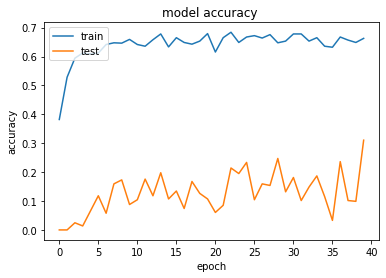

In [ ]:
over_Y_split = list(map(lambda x: [*x], over_Y))
over_Y_split = np.array(over_Y_split, dtype = 'int32')

history = dnn_mlp.fit(over_X, over_Y_split, epochs=40, validation_split=0.3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Single-label DL-MLP without class imbalance

[0.6992924809455872, 0.7146226167678833, 0.7146226167678833, 0.7169811129570007, 0.739386796951294, 0.7641509175300598, 0.7806603908538818, 0.7653301954269409, 0.7594339847564697, 0.7794811129570007, 0.7841981053352356, 0.7924528121948242, 0.7841981053352356, 0.7794811129570007, 0.7936320900917053, 0.7794811129570007, 0.786556601524353, 0.8030660152435303, 0.7948113083839417, 0.8113207817077637, 0.8172169923782349, 0.8172169923782349, 0.8502358198165894, 0.8242924809455872, 0.8136792182922363, 0.8349056839942932, 0.8408018946647644, 0.8207547068595886, 0.8396226167678833, 0.838443398475647, 0.8337264060974121, 0.8360849022865295, 0.8172169923782349, 0.8266509175300598, 0.8278301954269409, 0.8266509175300598, 0.8148584961891174, 0.838443398475647, 0.8502358198165894, 0.8372641801834106]
[0.0, 0.0, 0.0, 0.19505494832992554, 0.14560440182685852, 0.19505494832992554, 0.32692307233810425, 0.1318681389093399, 0.24725274741649628, 0.3461538553237915, 0.36263737082481384, 0.29395604133605957, 

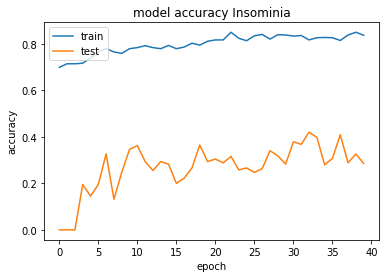

[0.6462264060974121, 0.7016509175300598, 0.8514150977134705, 0.8702830076217651, 0.8867924809455872, 0.9080188870429993, 0.9091981053352356, 0.9127358198165894, 0.9091981053352356, 0.9292452931404114, 0.9398584961891174, 0.9257075190544128, 0.9198113083839417, 0.9327830076217651, 0.9363207817077637, 0.9292452931404114, 0.9257075190544128, 0.9327830076217651, 0.9316037893295288, 0.9363207817077637, 0.9292452931404114, 0.9339622855186462, 0.9363207817077637, 0.9257075190544128, 0.9386792182922363, 0.9398584961891174, 0.9469339847564697, 0.9410377144813538, 0.9445754885673523, 0.9386792182922363, 0.9587264060974121, 0.9339622855186462, 0.9410377144813538, 0.9457547068595886, 0.9422169923782349, 0.9292452931404114, 0.9375, 0.9457547068595886, 0.9445754885673523, 0.9209905862808228]
[0.6978021860122681, 0.8708791136741638, 0.7527472376823425, 0.7390109896659851, 0.8021978139877319, 0.807692289352417, 0.7637362480163574, 0.8324176073074341, 0.8214285969734192, 0.8296703100204468, 0.840659320

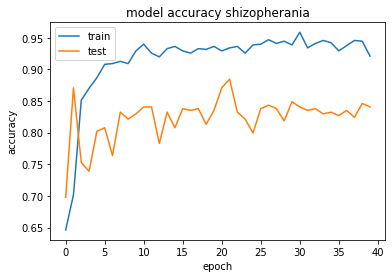

[0.4941037595272064, 0.5200471878051758, 0.5377358198165894, 0.5625, 0.5860849022865295, 0.6426886916160583, 0.6816037893295288, 0.676886796951294, 0.7346698045730591, 0.7370283007621765, 0.7547169923782349, 0.7688679099082947, 0.7653301954269409, 0.7688679099082947, 0.7889150977134705, 0.7735849022865295, 0.7936320900917053, 0.7948113083839417, 0.7924528121948242, 0.7983490824699402, 0.7948113083839417, 0.8077830076217651, 0.8278301954269409, 0.8042452931404114, 0.8113207817077637, 0.8113207817077637, 0.8007075190544128, 0.7995283007621765, 0.7771226167678833, 0.7900943160057068, 0.7995283007621765, 0.7924528121948242, 0.8195754885673523, 0.8242924809455872, 0.8195754885673523, 0.8183962106704712, 0.8042452931404114, 0.7771226167678833, 0.7983490824699402, 0.7818396091461182]
[0.450549453496933, 0.44505494832992554, 0.3928571343421936, 0.6071428656578064, 0.6428571343421936, 0.7390109896659851, 0.7307692170143127, 0.7115384340286255, 0.7307692170143127, 0.7307692170143127, 0.733516454

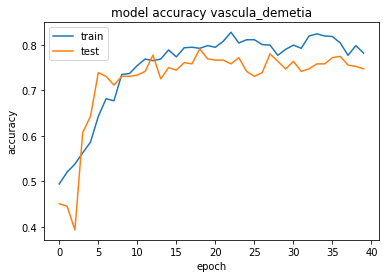

[0.6533018946647644, 0.6945754885673523, 0.6945754885673523, 0.6945754885673523, 0.6922169923782349, 0.7193396091461182, 0.7004716992378235, 0.7712264060974121, 0.7287735939025879, 0.7535377144813538, 0.7488207817077637, 0.7464622855186462, 0.7712264060974121, 0.7700471878051758, 0.7735849022865295, 0.7676886916160583, 0.739386796951294, 0.7547169923782349, 0.7617924809455872, 0.7783018946647644, 0.7594339847564697, 0.7724056839942932, 0.7794811129570007, 0.7948113083839417, 0.7771226167678833, 0.7889150977134705, 0.7841981053352356, 0.7747641801834106, 0.7900943160057068, 0.7783018946647644, 0.7570754885673523, 0.7617924809455872, 0.7924528121948242, 0.7676886916160583, 0.7794811129570007, 0.7995283007621765, 0.7889150977134705, 0.7806603908538818, 0.7747641801834106, 0.7853773832321167]
[0.6016483306884766, 0.6016483306884766, 0.6016483306884766, 0.6016483306884766, 0.6043956279754639, 0.6016483306884766, 0.6291208863258362, 0.6126373410224915, 0.6401098966598511, 0.7225274443626404,

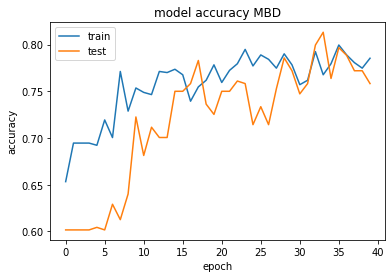

[0.698113203048706, 0.7146226167678833, 0.7146226167678833, 0.7146226167678833, 0.7146226167678833, 0.7146226167678833, 0.7146226167678833, 0.7146226167678833, 0.7146226167678833, 0.7476415038108826, 0.7441037893295288, 0.7358490824699402, 0.7570754885673523, 0.7818396091461182, 0.7594339847564697, 0.7523584961891174, 0.7712264060974121, 0.7912735939025879, 0.7735849022865295, 0.7841981053352356, 0.7712264060974121, 0.7700471878051758, 0.786556601524353, 0.7806603908538818, 0.7688679099082947, 0.7783018946647644, 0.7853773832321167, 0.7830188870429993, 0.7995283007621765, 0.8160377144813538, 0.8125, 0.7924528121948242, 0.8042452931404114, 0.8242924809455872, 0.8089622855186462, 0.7900943160057068, 0.7889150977134705, 0.7995283007621765, 0.8077830076217651, 0.8054245114326477]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3076923191547394, 0.43406593799591064, 0.0, 0.3324175775051117, 0.37362638115882874, 0.36263737082481384, 0.18406593799591064, 0.33791208267211914, 0.390109896659851

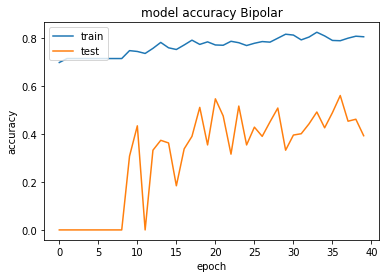

In [ ]:
deseases = ['Insominia',	'shizopherania',	'vascula_demetia',	'MBD',	'Bipolar']
drop_out_rates = [0.2, 0.5, 0.5, 0.4, 0.3]
for i, desease in enumerate(deseases):
  dnn_mlp_single = build_mlp_model(1, dropout_rate=drop_out_rates[i])
  history = dnn_mlp_single.fit(over_X, over_Y_split[:, i], epochs=40, validation_split=0.3, verbose = 0)
  print(history.history['accuracy'])
  print(history.history['val_accuracy'])
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy ' + desease)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## ML With Imbalance

### ML mlp

[0.3085714280605316, 0.4028571546077728, 0.44857141375541687, 0.44285714626312256, 0.47999998927116394, 0.5057142972946167, 0.508571445941925, 0.488571435213089, 0.5114285945892334, 0.5057142972946167, 0.5114285945892334, 0.488571435213089, 0.49714285135269165, 0.49142858386039734, 0.4628571569919586, 0.508571445941925, 0.4571428596973419, 0.488571435213089, 0.46857142448425293, 0.477142870426178, 0.47428572177886963, 0.48571428656578064, 0.4828571379184723, 0.48571428656578064, 0.488571435213089, 0.4657142758369446, 0.47428572177886963, 0.47999998927116394, 0.4399999976158142, 0.4714285731315613, 0.46857142448425293, 0.477142870426178, 0.46857142448425293, 0.48571428656578064, 0.4657142758369446, 0.4828571379184723, 0.4828571379184723, 0.4457142949104309, 0.4714285731315613, 0.44857141375541687]
[0.6800000071525574, 0.7333333492279053, 0.7200000286102295, 0.7599999904632568, 0.7799999713897705, 0.8133333325386047, 0.8133333325386047, 0.7799999713897705, 0.8199999928474426, 0.800000011

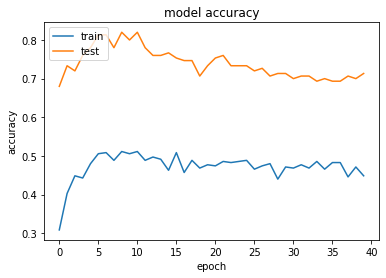

In [ ]:
ml_mlp = build_mlp_model(5, single_layer=True)
history = ml_mlp.fit(X, Y, epochs=40, validation_split=0.3, verbose = 0)
print(history.history['accuracy'])
print(history.history['val_accuracy'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### ML SVM

In [28]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)
clf = svm.SVC(random_state=RANDOM_STATE)
scores = cross_val_score(clf, X, multi_hot_Y, cv=cv, scoring='accuracy')

In [17]:
scores

array([0.39, 0.39, 0.36, 0.42, 0.39])

In [18]:
scores.mean()

0.39

### ML RF

In [ ]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=20)
scores = cross_val_score(clf, X, multi_hot_Y, cv=cv, scoring='accuracy')

In [ ]:
scores

array([0.3 , 0.3 , 0.3 , 0.27, 0.34])

In [ ]:
scores.mean()

0.302

### ML DT

In [ ]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=20)
scores = cross_val_score(clf, X, multi_hot_Y, cv=cv, scoring='accuracy')

In [ ]:
scores

array([0.23, 0.28, 0.24, 0.24, 0.29])

In [ ]:
scores.mean()

0.256

## ML Without Imbalance

### ML MLP

[0.4103773534297943, 0.614386796951294, 0.6273584961891174, 0.6191037893295288, 0.6202830076217651, 0.6120283007621765, 0.6426886916160583, 0.6214622855186462, 0.650943398475647, 0.6344339847564697, 0.6308962106704712, 0.650943398475647, 0.6344339847564697, 0.625, 0.6568396091461182, 0.661556601524353, 0.6533018946647644, 0.6415094137191772, 0.6462264060974121, 0.6603773832321167, 0.6462264060974121, 0.6816037893295288, 0.6521226167678833, 0.661556601524353, 0.6426886916160583, 0.6804245114326477, 0.6462264060974121, 0.6827830076217651, 0.6591981053352356, 0.6698113083839417, 0.6733490824699402, 0.6627358198165894, 0.6804245114326477, 0.6650943160057068, 0.6485849022865295, 0.676886796951294, 0.6450471878051758, 0.6474056839942932, 0.6804245114326477, 0.6780660152435303]
[0.005494505632668734, 0.14560440182685852, 0.1538461595773697, 0.06868132203817368, 0.1318681389093399, 0.05219780281186104, 0.07692307978868484, 0.1428571492433548, 0.05219780281186104, 0.04395604506134987, 0.0851648

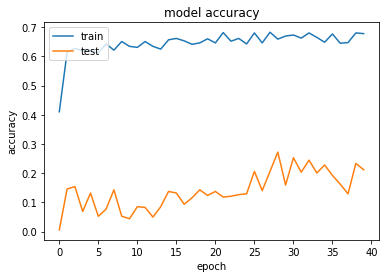

In [ ]:
ml_mlp = build_mlp_model(5, single_layer=True, dropout_rate=0.1)
history = ml_mlp.fit(over_X, over_Y_split, epochs=40, validation_split=0.3, verbose = 0)
print(history.history['accuracy'])
print(history.history['val_accuracy'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### ML SVM

In [24]:
clf = svm.SVC(random_state=RANDOM_STATE)
scores = cross_val_score(clf, over_X, over_Y, cv=cv, scoring='accuracy')

In [25]:
scores

array([0.57613169, 0.66255144, 0.65020576, 0.63786008, 0.59259259])

In [26]:
scores.mean()

0.6238683127572016

### ML RF

In [ ]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=20)
scores = cross_val_score(clf, over_X, over_Y, cv=cv, scoring='accuracy')

In [ ]:
scores

array([0.63374486, 0.7037037 , 0.6872428 , 0.65432099, 0.64197531])

In [ ]:
scores.mean()

0.6641975308641976

### ML DT

In [ ]:
clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=20)
scores = cross_val_score(clf, over_X, over_Y, cv=cv, scoring='accuracy')

In [ ]:
scores

array([0.57613169, 0.67489712, 0.64197531, 0.59670782, 0.59259259])

In [ ]:
scores.mean()

0.6164609053497943

## Correlation

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DLH deep learning in healthcare/dlh-data.csv')
columns = df.columns

In [ ]:
np.unique(df['occupation'])

array(['ARTISAN', 'C/SERVANT', 'FORCE', 'RETIRED', 'STUDENT', 'UNEMPLYD'],
      dtype=object)

In [ ]:
np.unique(df['religion'])

array(['C', 'M', 'O'], dtype=object)

In [ ]:
df = np.array(df)
df[df=='Yes'] = 1
df[df=='No'] = 0

df[df=='S'] = 1
df[df=='M'] = 2

df[df=='F'] = 1
df[df=='M'] = 2

df[df=='C'] = 1
df[df=='M'] = 2
df[df=='O'] = 3

df[df=='STUDENT'] = 1
df[df=='ARTISAN'] = 2
df[df=='C/SERVANT'] = 3
df[df=='FORCE'] = 4
df[df=='RETIRED'] = 5
df[df=='UNEMPLYD'] = 6

df[df=='P'] = 1
df[df=='P       \x1c'] = 1
df[df=='N'] = 0
df[df=='N       \x1a'] = 0
df = df.astype('int32')
df = pd.DataFrame(df, columns=columns)

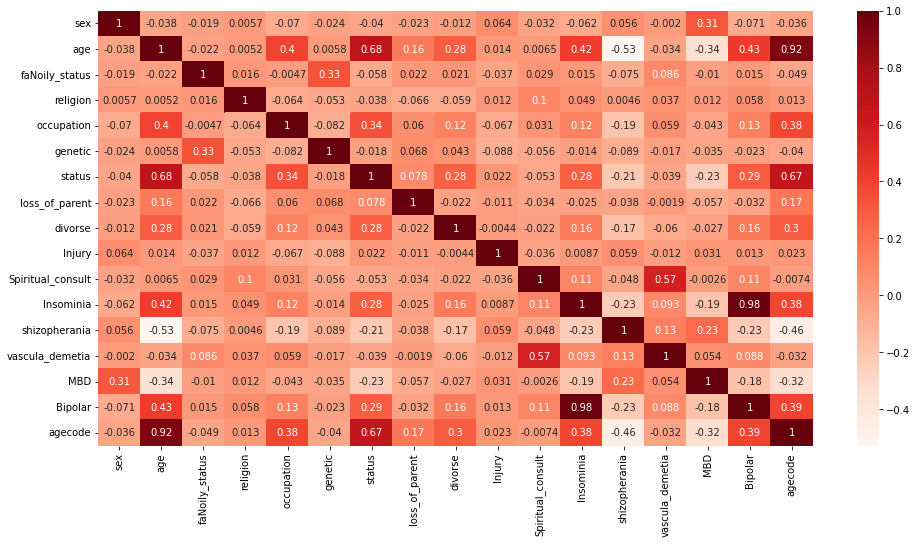

In [ ]:
plt.figure(figsize=(16,8))

cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=20)
clf.fit(over_X, over_Y)

RandomForestClassifier(max_depth=20, random_state=42)